In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
from os.path import join as opj
import tensorflow as tf
from tensorflow.python.client import device_lib
import astropy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import transit_utils as utils
import model_training_toolkit as modelkit


%matplotlib inline

from time import process_time

/var/folders/g6/3sy022nj17q9pf3kxl2bqh040000gn/T/ipykernel_64322/3579693199.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# If desired, Show available computational hardware

if 1:
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4969161551934225472
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 272797601987951073
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2024-07-10 12:44:45.282555: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-10 12:44:45.282568: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-10 12:44:45.282575: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-10 12:44:45.282762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 12:44:45.282772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# **Hardware Choices:**
# 
# 0 = GPU 0 RTX 3090
# 1 = GPU 1 RTX 2080
# 2 = CPU

# What is your hardware choice
proc_hardware_choice = 0


if proc_hardware_choice == 0:
    proc_hardware_name = '/device:GPU:0'
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    
elif proc_hardware_choice == 1:
    proc_hardware_name = '/gpu:1'
    
elif proc_hardware_choice == 2:
    proc_hardware_name = '/cpu:0'
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print('ERROR: You didnt make a proper choice. Defaulting to CPU processing.')
    proc_hardware_name = '/device:CPU:0'
    
print('Using hardware name =', proc_hardware_name)

Using hardware name = /device:GPU:0


# Process the training data

In [4]:
#Load training data
# filelist = ['100K_transformed.npz']
filelist = ['recovery/training_data/5K_transformed.npz']
# filelist = ['recovery/training_data/5K_foldless_trainingdata.npz']

plc = []
nlc = []

for name in filelist:
    p = np.load(name)['poslc']
    n = np.load(name)['neglc']
    
    plc.append(p)
    nlc.append(n)
    
positive_matrix = np.vstack(plc)
negative_matrix = np.vstack(nlc)

(240,)


<IPython.core.display.Javascript object>


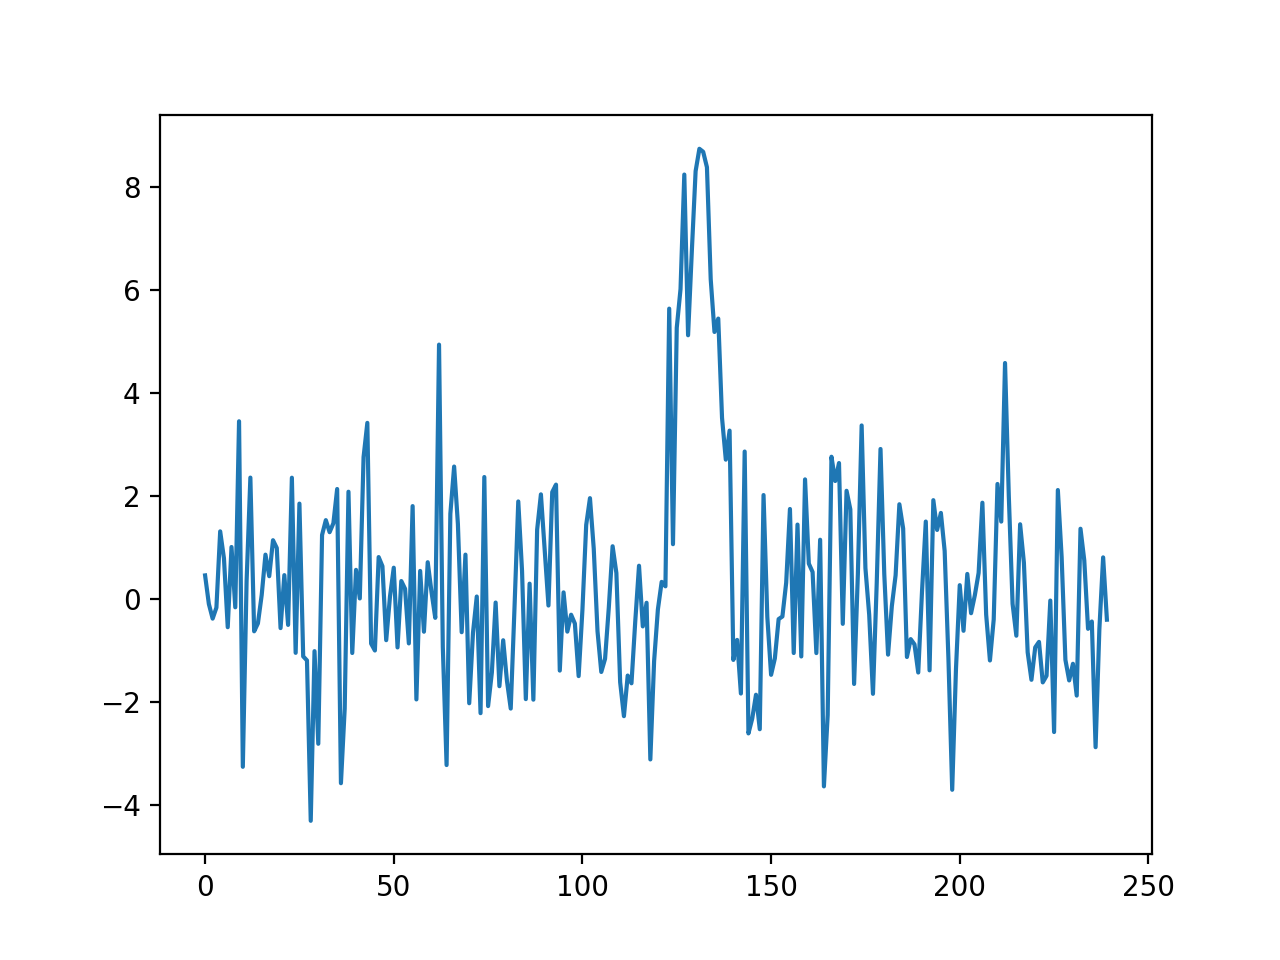

In [15]:
# Plot a sample from the loaded data as a sanity check.

i = np.random.randint(0, negative_matrix.shape[0])
print(np.shape(positive_matrix[i, :]))

plt.figure()
# plt.title(str(params[i, :]))
plt.plot(positive_matrix[i, :])
# plt.plot(time, transits_clean[i, :], '-m', alpha=0.5)

In [19]:
# Make testing and training datasets
x_train, y_train = modelkit.mk_set(positive_matrix, negative_matrix)


# Reshape arrays to make tensorflow happy.
y_test = y_train.reshape((-1, 1))
x_test = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

np.shape(x_train[1])

(240,)

# Run the training process

In [78]:
#################################
###### User Options #############
#################################

model_name = 'model_folded_v2' # This will be used in the file names to denote a specific model

batch_size = 32
epochs = 80
data_dir = os.path.join(os.getcwd(), 'data')
log_dir = os.path.join(os.getcwd(), 'tb_logs')
checkpoint_dir = os.path.join(os.getcwd(), 'data', 'models')

In [79]:
#New model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Input, Flatten, Reshape,
    GlobalMaxPooling1D, Lambda,
    Conv2D, GaussianNoise,
    Cropping2D, Concatenate, ZeroPadding2D)

tf.keras.backend.clear_session()

# -------------------------------------------------
# Circular Convolutional Layer

def CConv2D(filters, kernel_size, strides=(1, 1), activation='linear', padding='valid', kernel_initializer='glorot_uniform', kernel_regularizer=None):
    
    def CConv2D_inner(x):
        # padding (see https://www.tensorflow.org/api_guides/python/nn#Convolution)
        in_height = int(x.get_shape()[1])
        in_width = int(x.get_shape()[2])

        if (in_height % strides[0] == 0):
            pad_along_height = max(kernel_size[0] - strides[0], 0)
        else:
            pad_along_height = max(
                kernel_size[0] - (in_height % strides[0]), 0)
        if (in_width % strides[1] == 0):
            pad_along_width = max(kernel_size[1] - strides[1], 0)
        else:
            pad_along_width = max(kernel_size[1] - (in_width % strides[1]), 0)

        pad_top = pad_along_height // 2
        pad_bottom = pad_along_height - pad_top
        pad_left = pad_along_width // 2
        pad_right = pad_along_width - pad_left

        # left and right side for padding
        pad_left = Cropping2D(cropping=((0, 0), (in_width-pad_left, 0)))(x)
        pad_right = Cropping2D(cropping=((0, 0), (0, in_width-pad_right)))(x)

        # add padding to incoming image
        conc = Concatenate(axis=2)([pad_left, x, pad_right])

        # top/bottom padding options
        if padding == 'same':
            conc = ZeroPadding2D(padding={'top_pad': pad_top,
                                          'bottom_pad': pad_bottom})(conc)
        elif padding == 'valid':
            pass
        else:
            raise Exception('Padding "{}" does not exist!'.format(padding))

        # perform the circular convolution
        cconv2d = Conv2D(filters=filters, kernel_size=kernel_size,
                         strides=strides, activation=activation,
                         padding='valid',
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=kernel_regularizer)(conc)

        # return circular convolution layer
        return cconv2d
    return CConv2D_inner


# -------------------------------------------------
# The model

def model_fun(data_shape):

    inputs = Input(shape=data_shape)
    
    # New layer: Adds a small amount of noise to each sample during training
    layer = GaussianNoise(stddev=1/100)(inputs)
    
    # New layer: Make tensor 2D for new 2D convolution layers
    layer = Reshape((1, data_shape[0], 1))(layer)
    
    # New layer: Circular convolution layer
    layer = CConv2D(
        filters=128, 
        kernel_size=(1,3), 
        activation='linear',
    )(layer) #Q - how to get 512 parameters from this?
    
    # New layer: Circular convolution layer
    cconv2_filter_cnt = 256
    layer = CConv2D(
        filters=cconv2_filter_cnt, 
        kernel_size=(1,6), 
        activation='linear',
    )(layer)
    
    # New layer: Make tensor 1D
    layer = Reshape((data_shape[0], 
                     cconv2_filter_cnt))(layer)
    
    # New layer: Global pooling
    layer = GlobalMaxPooling1D()(layer)
    
    layer = Flatten()(layer)

    layer = Dense(256, activation='relu')(layer)
    
    layer = Dense(256, activation='relu')(layer)
    
    layer = Dense(1, activation='sigmoid')(layer)
    
    return Model(inputs, layer)

# Create model
model = model_fun(x_train.shape[1:])

# Show model summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 1)]     0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 240, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 240, 1)    0           gaussian_noise[0][0]             
__________________________________________________________________________________________________
cropping2d (Cropping2D)         (None, 1, 1, 1)      0           reshape[0][0]                    
_______________________________________________________________________________________

In [80]:
# Train and test the model
# import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

# Set optimizer and optimization options
# optimizer = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = Adam(lr=5e-7)

# Compile the model (required)
model.compile(loss='binary_crossentropy', 
              #optimizer= 'adam',
              optimizer = optimizer,
              metrics=['accuracy'])


# Set early stopping (during training) options
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=7, 
                               verbose=1, 
                               mode='auto')


# Setup training checkpoint options
model_checkpoint = ModelCheckpoint(opj(checkpoint_dir, str(model_name) + '.hdf5'), 
                                   monitor='val_loss', 
                                   save_best_only=True)


# Define callbacks, which TF will call on after each training epoch finishes
callbacks = [model_checkpoint,  # Make checkpoints
             PlotLossesCallback(), # Show training progress (model accuracy and loss)
            ]

In [81]:
# Ensure you are using the hardware you wanted for training
proc_hardware_name

'/gpu:0'

In [82]:
%matplotlib inline
# Make sure plots are "inline" not "notebook". Required for progress plots to work.

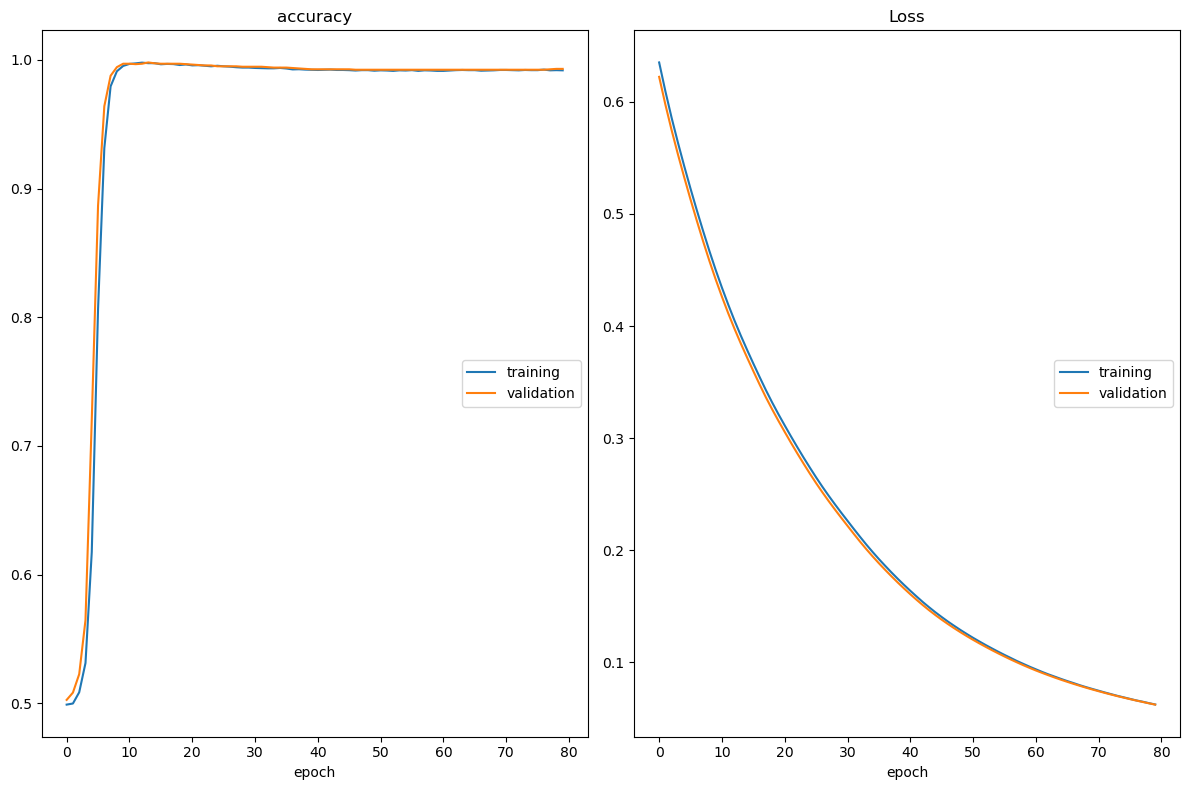

accuracy
	training         	 (min:    0.499, max:    0.998, cur:    0.992)
	validation       	 (min:    0.503, max:    0.998, cur:    0.993)
Loss
	training         	 (min:    0.063, max:    0.635, cur:    0.063)
	validation       	 (min:    0.062, max:    0.622, cur:    0.062)
219/219 [==============================] - 2s 7ms/step - loss: 0.0625 - accuracy: 0.9919 - val_loss: 0.0624 - val_accuracy: 0.9930


In [83]:
# Train the model!

# You can press the stop button in jupyter if you feel that its trained enough and further
# training wont improve considerably.

print(proc_hardware_name)

with tf.device(proc_hardware_name): # With the hardware chosen, train the model!
    
    model.fit(x_train, y_train,
              batch_size=batch_size, 
              epochs=epochs,
              validation_split=0.3,
              shuffle=True,
              callbacks=callbacks,
             )

In [16]:
# Load the model weights at the checkpoint which had the best results (typically the last epoch, but not always)
model.load_weights(opj(data_dir, 'models', str(model_name) + '.hdf5'))

In [17]:
# Save the entire model so that you can load the model later to run data through the model
model.save(opj(data_dir, 'models', str(model_name) + '_save1.hd5'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2023-08-20 16:02:52.844447: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /media/rd1/rliu/data/models/model_folded_v2_save1.hd5/assets


# Evaluate the accuracy of the trained model

In [8]:
from tensorflow.keras.models import load_model
with tf.device(proc_hardware_name):
    model = load_model("./data/models/model_single_v3_save1.hd5")

In [26]:
# Run the test data through the model to determine its accuracy

print(np.shape(x_test))

with tf.device(proc_hardware_name): # With the hardware chosen, test the model!
    
    y_pred = model.predict(x_test)
    y_pred = np.around(y_pred)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
    
print('accuracy_score  =', modelkit.nstr(accuracy_score(y_test, y_pred.round())) )
print('precision_score =', modelkit.nstr(precision_score(y_test, y_pred.round())) )
print('recall_score    =', modelkit.nstr(recall_score(y_test, y_pred.round())) )
print('f1_score        =', modelkit.nstr(f1_score(y_test, y_pred.round())) )
print('roc_auc_score   =', modelkit.nstr(roc_auc_score(y_test, y_pred.round())) )

(10000, 240, 1)
accuracy_score  = 1.0
precision_score = 1.0
recall_score    = 1.0
f1_score        = 1.0
roc_auc_score   = 1.0


<IPython.core.display.Javascript object>


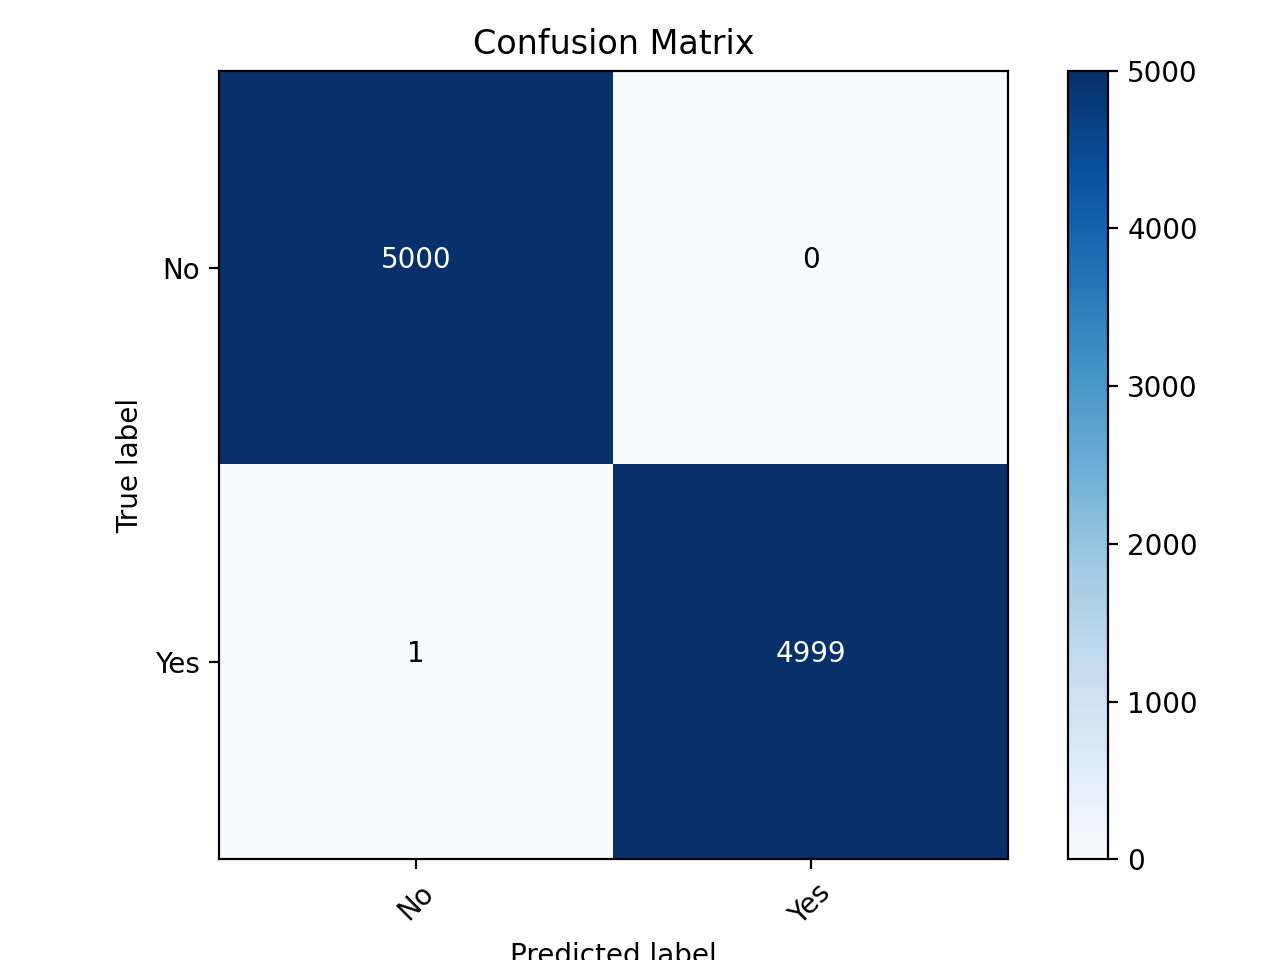

Confusion matrix, without normalization
[[5000    0]
 [   1 4999]]


In [11]:
# Make an extremely useful plot showing false-positives, true-negatives, etc.

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, 
                      y_pred=y_pred)

modelkit.plot_confusion_matrix(cm=cm, 
                      classes=['No','Yes'], 
                      title='Confusion Matrix');



#Validation: Try different periods through the range with t0 at given transit candidates. Exclude folds with very low SNR immediately and feed rest into model.

# Manufacture artificial data to use

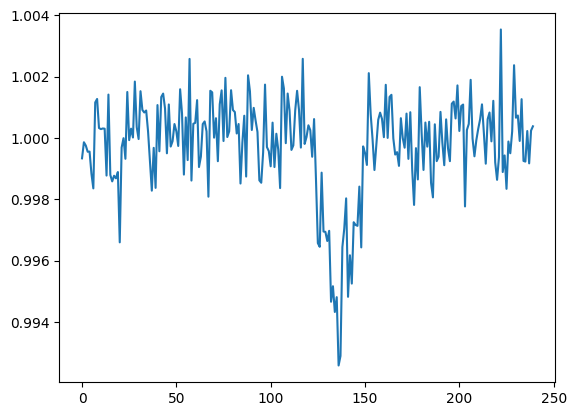

In [184]:
dur = np.random.uniform(0.2,0.8)
depth = np.random.uniform(0.001,0.01)
ratio = np.random.uniform(0.005,0.1)
snr = np.random.uniform(2,8)
otr = utils.make_transit(2.5, 5, dur, depth, ratio, resolution=1/48)

sigma = depth * np.sqrt(dur) / snr * 1.5
noise = np.random.normal(0.0, sigma, len(otr))
sin_noise = np.sin(np.linspace(0,np.pi*np.random.randint(1,4),num=240))*np.random.uniform(0,0.001)

otr += noise
otr += sin_noise

plt.figure()
plt.plot(otr)

In [178]:
#Make samples for the unfolded approach
n_samples = 1000

negative_tr = []
positive_tr = []

for i in range(n_samples):
    dur = np.random.uniform(0.05,0.5)
    depth = np.random.uniform(0.0001,0.01)
    ratio = np.random.uniform(0.001,0.1)
    snr = np.random.uniform(2,8)
    otr = utils.make_transit(2.5, 5, dur, depth, ratio, resolution=1/48)

    sigma = depth * np.sqrt(dur) / snr
    noise = np.random.normal(0.0, sigma, len(otr))

    otr += noise
    
    negative_tr.append(noise + 1)
    positive_tr.append(otr)
    
    name = "100K_foldless_trainingdata.npz"


ntr = np.stack(negative_tr, axis = 0)
ptr = np.stack(positive_tr, axis = 0)

# np.savez(name, neglc = ntr, poslc = ptr)

<IPython.core.display.Javascript object>


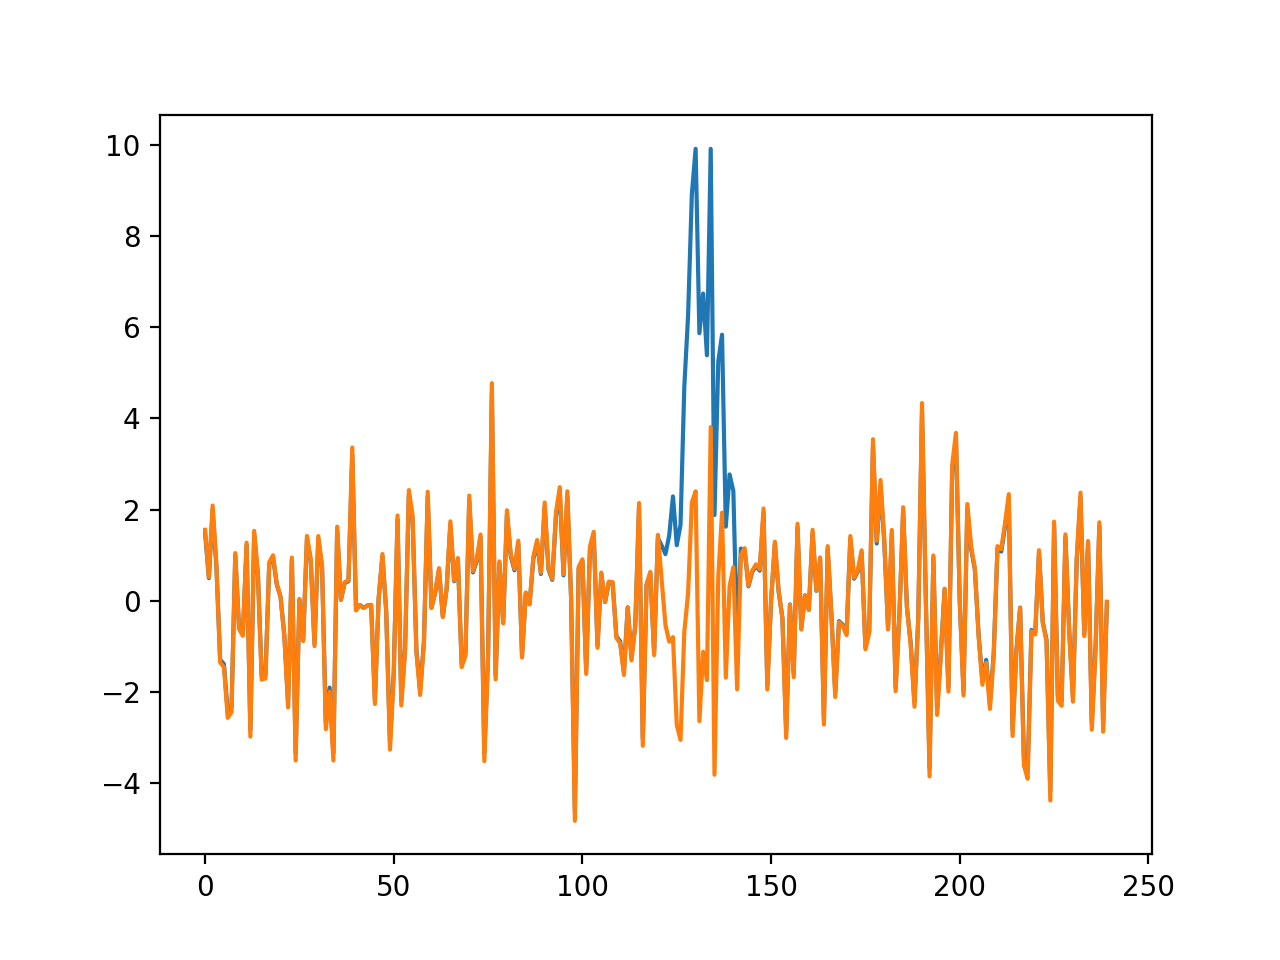

In [7]:
filelist = ['100K_foldless_trainingdata.npz']

plc = []
nlc = []

p_transform = []
n_transform = []

for name in filelist:
    p = np.load(name)['poslc']
    n = np.load(name)['neglc']
    
    plc.append(p)
    nlc.append(n)

    
n_sigma = 2
#n_sigma = 20

for fold in plc:
    fold_sigma =  astropy.stats.sigma_clipped_stats(fold)[2]
    folds_norm = (1 - fold) / (n_sigma*fold_sigma)  # get most of the data into (-1,1) with the multiplier to fold_sigma
    p_transform.append(folds_norm)
    
for fold in nlc:
    fold_sigma =  astropy.stats.sigma_clipped_stats(fold)[2]
    folds_norm = (1 - fold) / (n_sigma*fold_sigma)  # get most of the data into (-1,1) with the multiplier to fold_sigma
    n_transform.append(folds_norm)

p_final = np.vstack(p_transform)
n_final = np.vstack(n_transform)

np.savez('100K_foldless_transformed.npz', neglc = n_final, poslc = p_final)

plt.figure()
plt.plot(p_final[5])
plt.plot(n_final[5])